# The Arena

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy
from alphazero.gomoku_game import GomokuGame as Gomoku, initial_stones
from alphazero.mcts import MCTS

In [3]:
BOARD_SIZE=15

In [6]:
from domoku.policies.heuristic_policy import HeuristicPolicy
from alphazero.gomoku_players import HeuristicPlayer

stones = "C11F9E9G8F7G7G9H8I8H7I6I9F6H6H9I5J4"

detector = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
gomoku = Gomoku(BOARD_SIZE, detector=detector, initial=initial_stones(BOARD_SIZE, 4))

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


### The Current Champion

In [7]:
policy_d = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
mcts_d = MCTS(gomoku, policy_d, cpuct=1.0, num_simulations=100, model_threshold=.4)
defender = HeuristicPlayer(name="Charlie Champion", mcts=mcts_d, temperature=0.3)

### The Challenger
Obviously, we choose a much stronger challenger

In [8]:
policy_c = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
mcts_c = MCTS(gomoku, policy_c, cpuct=1.0, num_simulations=100, model_threshold=.4)
challenger = HeuristicPlayer(name="Chubbie Challenger", mcts=mcts_c, temperature=0.0)

## Let The Games Begin!!

In [9]:
from alphazero.arena import Arena
from domoku.board import GomokuBoard as LegacyBoard

arena = Arena(challenger, defender, gomoku, max_moves=100)

player = arena.play_game(verbose=1)
if player is not None:
    print(f"Congrats: {player.name}")

board = deepcopy(arena.board)
stones = "".join([str(stone) for stone in board.stones])
board_t = LegacyBoard(n=BOARD_SIZE, disp_width=10, stones=stones, heuristics=policy_c)

Chubbie Challenger to begin with black.
Chubbie Challenger: J5
Charlie Champion: J8
Chubbie Challenger: K9
Charlie Champion: J4
Chubbie Challenger: K6
Charlie Champion: K8
Chubbie Challenger: L7
Charlie Champion: I4
Chubbie Challenger: M8
Charlie Champion: N9
Chubbie Challenger: L6
Charlie Champion: M6
Chubbie Challenger: L5
Charlie Champion: L4
Chubbie Challenger: K4
Charlie Champion: J10
Chubbie Challenger: K5
Charlie Champion: M5
Chubbie Challenger: K3
Charlie Champion: K7
Chubbie Challenger: K2
Chubbie Challenger (black) won.
Congrats: Chubbie Challenger


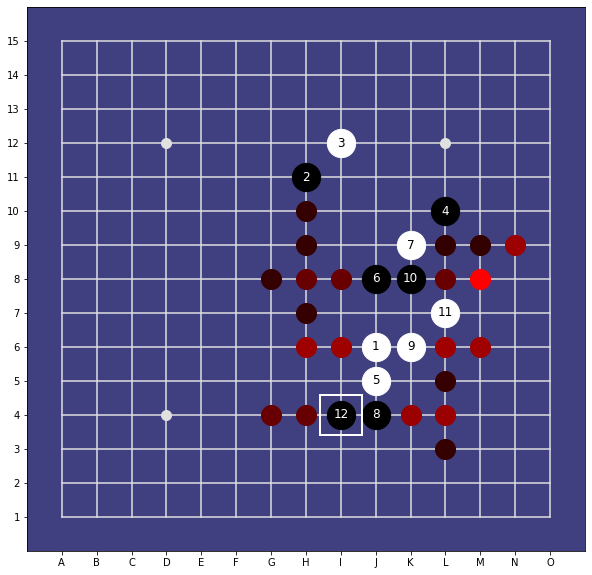

In [23]:
board_t.display()
board_t.bwd();

In [24]:
res = arena.play_games(2)

Arena.play_games (2): 100%|██████████| 1/1 [02:55<00:00, 175.82s/it]


In [25]:
res

{Chubbie Challenger: 1, Charlie Champion: 1, 'draws': 0}

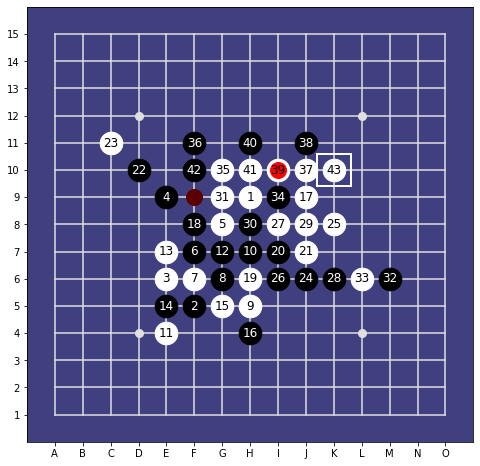

In [27]:
board = deepcopy(arena.board)
stones = "".join([str(stone) for stone in board.stones])
board_t = LegacyBoard(n=BOARD_SIZE, disp_width=8, stones=stones, heuristics=policy_c)
board_t.display()